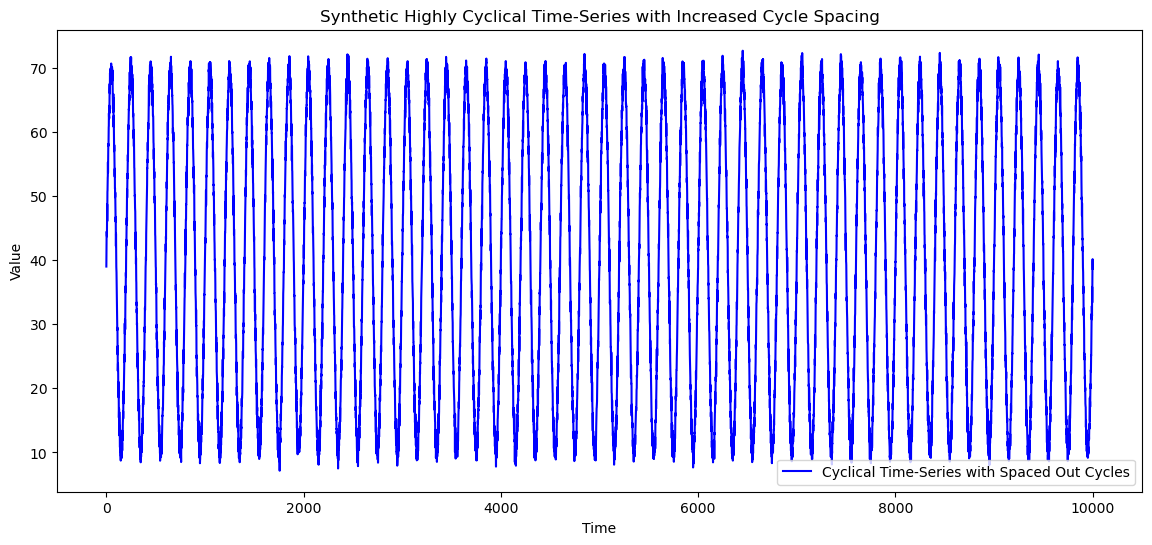

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from config import seq_length

# Number of data points
n_points = 10000

# Generate a time array
time = np.linspace(0, 10000, n_points)

# Generate a cyclical time-series using a sinusoidal function with an increased period
# Increase the period from 50 to 100 to space out the cycles
data = 30 * np.sin(2 * np.pi * time / 200) + 40  # Adjusted period

# Adding some noise
noise = np.random.normal(0, 1, n_points)  # Reduced standard deviation
data_with_noise = data + noise

# Plotting the generated time-series
plt.figure(figsize=(14, 6))
plt.plot(time, data_with_noise, label='Cyclical Time-Series with Spaced Out Cycles', color='blue')
plt.title('Synthetic Highly Cyclical Time-Series with Increased Cycle Spacing')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [2]:
def adjust_to_three_sigma(feature_list):
    percentile_1st = np.percentile(feature_list, 0.3)
    percentile_99th = np.percentile(feature_list, 99.7)
    feature_list_capped = [max(min(x, percentile_99th), percentile_1st) for x in feature_list]
    plt.plot(feature_list_capped)
    return feature_list_capped

def adjust_top_one_pct(feature_list):
    percentile_1st = np.percentile(feature_list, 1)
    percentile_99th = np.percentile(feature_list, 99)
    feature_list_capped = [max(min(x, percentile_99th), percentile_1st) for x in feature_list]
    return feature_list_capped

# Standardize with zero mean and 1 variance
def standardize_and_plot(feature_list):
    feature_list = np.array(feature_list)
    mean = np.mean(feature_list)
    std_dev = np.std(feature_list)
    feature_list_standardized = (feature_list - mean) / std_dev
    print("Standardized mean:", np.mean(feature_list_standardized))
    print("Standardized variance:", np.var(feature_list_standardized))
    plt.hist(feature_list_standardized, bins='auto')
    plt.title('Standardized to zero mean and unit variance')
    plt.xlabel('Standardized Value')
    plt.ylabel('Frequency')
    plt.show()
    return feature_list_standardized

In [3]:
stock_df = pd.DataFrame()
stock_df["close"] = data_with_noise

features_df = pd.DataFrame(index=stock_df.index)

In [4]:
for i in range(1, len(stock_df)):
    if stock_df["close"].iloc[i] / stock_df["close"].iloc[i-1] > 5:
        print(i)
        print(stock_df.iloc[i])
        print(stock_df.iloc[i-1])

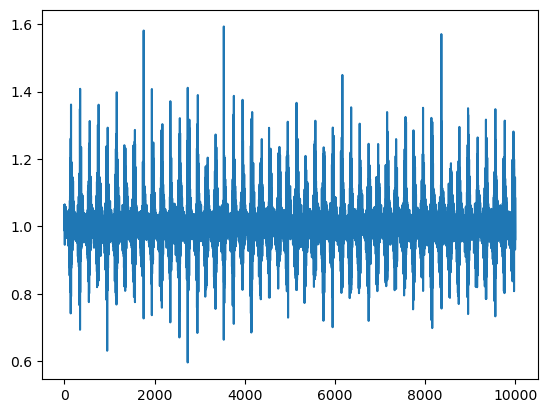

In [5]:
labels = stock_df['close'].values
labels = [1.0] + [labels[i] / labels[i-1] for i in range(1, len(labels))]
labels = np.array(labels)


# 1. Relative change
curr_close_prev_close_rel = [1.0] + [stock_df['close'].iloc[i] / stock_df['close'].iloc[i-1] for i in range(1, len(stock_df))]
plt.plot(curr_close_prev_close_rel)


Standardized mean: -9.308109838457313e-17
Standardized variance: 1.0


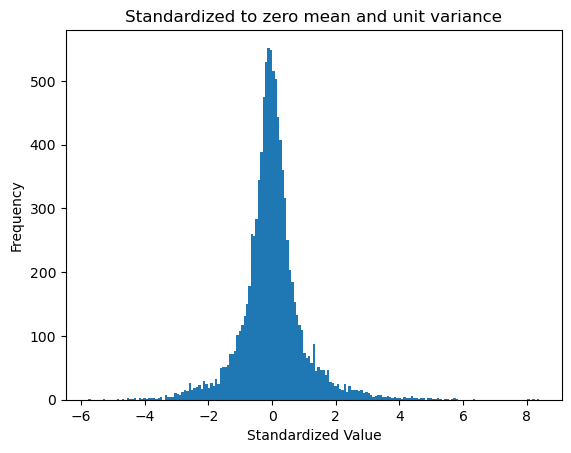

In [6]:
curr_close_prev_close_rel_std = standardize_and_plot(curr_close_prev_close_rel)
features_df["curr_close_prev_close_rel_std"] = curr_close_prev_close_rel_std

In [7]:
def create_sequences(data, labels):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = labels[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys).reshape(-1, 1)

total_length = len(features_df)
split_idx = int(total_length * 0.8) + seq_length
val_test_idx = int(total_length * 0.9) + seq_length

train_df = features_df.iloc[:split_idx]
val_df = features_df.iloc[split_idx:val_test_idx]
test_df = features_df.iloc[val_test_idx:]

train_labels = labels[:split_idx]
val_labels = labels[split_idx:val_test_idx]
test_labels = labels[val_test_idx:]

feature_scaler = {}
train_normalized = train_df.copy()
val_normalized = val_df.copy()
test_normalized = test_df.copy()

for column in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_normalized[column] = scaler.fit_transform(train_df[column].values.reshape(-1, 1)).flatten()
    val_normalized[column] = scaler.transform(val_df[column].values.reshape(-1, 1)).flatten()
    test_normalized[column] = scaler.transform(test_df[column].values.reshape(-1, 1)).flatten()
    feature_scaler[column] = scaler

label_scaler = MinMaxScaler(feature_range=(-1, 1))
train_labels_scaled = label_scaler.fit_transform(train_labels.reshape(-1, 1))
val_labels_scaled = label_scaler.transform(val_labels.reshape(-1, 1))
test_labels_scaled = label_scaler.transform(test_labels.reshape(-1, 1))

X_train, y_train = create_sequences(train_normalized.values, train_labels_scaled.flatten())
X_val, y_val = create_sequences(val_normalized.values, val_labels_scaled.flatten())
X_test, y_test = create_sequences(test_normalized.values, test_labels_scaled.flatten())

# num_workers = 15 (home pc), max_workers = 10 (mac)
train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=False, 
                                            num_workers=10, persistent_workers=True)
val_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)), batch_size=64, shuffle=False, 
                                            num_workers=10, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test)), batch_size=64, shuffle=False, 
                                            num_workers=10, persistent_workers=True)